In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
from antea.elec import tof_functions as wvf 
from scipy import signal
from scipy.optimize import leastsq
from scipy.optimize import least_squares
%matplotlib nbagg
%reload_ext autoreload
%autoreload 2

In [2]:
# Time unit (tu) -> 100 ps
# Simulation Time Step -> 5ns (50 tu)
time_unit = 100E-12
time_step = 50
#TIME_rnd = np.add.accumulate(np.random.poisson(9,100))
#PE_rnd   = np.random.choice([1,2],100,replace=True,p=[0.95,0.05])
TIME_rnd     = np.array([ 500, 570,1000,1040,1060,1100,1110,1160,1200,1230,1300,
                          1400,1440,1460,1500,1510,1560,1600,1630,1700,1710,1750])
PE_rnd       = np.array([   1,   4,  30,  40,  25,  15,  20,  25,  30,  10,   4,   
                           25,  35,  20,  10,  40,  30,  15,  10,   5,   4,   1])

TIME         = np.arange(0,100000,100)
PE           = np.arange(0,1000)

In [3]:
def find_nearest_bigger(A,val):
    return np.where(A-val > 0, A-val, np.inf).argmin()

In [4]:
# Waveform generator
def wave_gen(pe_time_zs:np.array) -> Tuple[np.array,np.array]:
    
    # Constants
    q = 1.6021E-19
    #Electron charge
    SIPM_gain = 500000
    # Time unit (tu) -> 100 ps
    # Simulation Time Step -> 5ns (50 tu)
    
    spe_response,norm = wvf.apply_spe_dist(np.arange(0,20000),[10,500])
    spe_response_C = spe_response * SIPM_gain * q 
    #spe_response in Coulombs
    spe_response_A = spe_response_C / (time_unit)
    #spe_response in Amperes
    
    print("CHECK: Electrons in spe_response = %f" % (np.sum(spe_response_A)*time_unit/q/SIPM_gain))
    
    time = np.arange(0,pe_time_zs[0,-1]*time_step+len(spe_response_A))
    pe   = np.zeros(pe_time_zs[0,-1]*time_step+len(spe_response_A))
    pe[pe_time_zs[0,:]*time_step] = pe_time_zs[1,:]  
    
    # C. Romo convolution
    wave = wvf.convolve_tof(spe_response_A,pe)
    return time,wave

In [5]:
time,wave = wave_gen(np.vstack([TIME,PE]))

CHECK: Electrons in spe_response = 1.000000


# Bandwidth limit

In [6]:
# Shaping based on bandwidth guess
f_sample = (1/time_unit); # Hz
BW_guess = 25E6; # Hz
#freq_LPF = 1/(100*1E-9); # rad/sec
freq_LPF = 2*np.pi*BW_guess; # rad/sec
freq_LPFd = freq_LPF / (f_sample*np.pi); # Normalized by Nyquist Freq (half-cycles/sample)
# Filter Definitions
b, a = signal.butter(1, freq_LPFd, 'low', analog=False)
signal_out = signal.lfilter(b,a,wave)

<IPython.core.display.Javascript object>


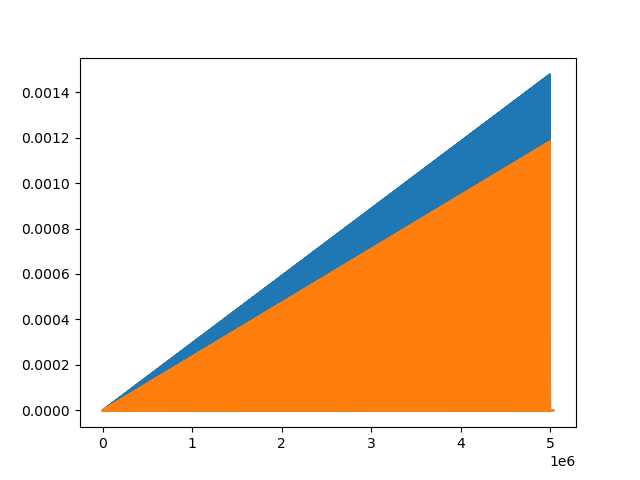

In [7]:
plt.figure()
plt.plot(wave)
plt.plot(signal_out)

# PROPOSAL 1: Square root  domain integrator

In [8]:
class mosfet(object):
    def __init__(self,**kwargs):
        self.KPP_2n = kwargs['KPP_2n']
        self.W_L = kwargs['W_L']
        self.VTH = kwargs['VTH']
    
    def iDS(self,vGS):
        i_DS_aux = self.KPP_2n*self.W_L*(vGS-self.VTH)**2
        return i_DS_aux
    
    def vGS(self,iDS):
        v_GS_aux = np.sqrt(iDS/(self.KPP_2n*self.W_L))+self.VTH
        return v_GS_aux

    
class capacitor(object):
    def __init__(self, C, time_unit):
        self.C = C
        self.time_unit = time_unit
    
    def iC(self,vC):
        # A first zero must be introduced to compensate for the one sample loss
        return np.diff(vC) * self.C / self.time_unit
    
    def vC(self, iC):
        return np.cumsum(iC) * (1.0/self.C) * self.time_unit

    
class translinear_loop(object):
    # Functions are written taking into account the usage of refined MOSFET models
    # to study the effect of inversion level changes etc.
    
    def __init__(self, KPP_2n=150E-6, W_L=10, VTH=0.55):
        self.MN_1 = mosfet(KPP_2n=KPP_2n, W_L=W_L,   VTH=VTH)
        self.MN_2 = mosfet(KPP_2n=KPP_2n, W_L=W_L * 4, VTH=VTH)
    
    def VTL_mult_div(self,vGS_C,I_A,sqrt_term):
        vGS_A = self.MN_1.vGS(I_A)
        return (self.MN_1.iDS(vGS_C)+I_A)-(self.MN_2.iDS((vGS_A+vGS_C)/2.0)-sqrt_term)
    
    def geo_mean(self,I_A,I_B):
        # Translinear loop follows basic eq. vGS_o = vGS_A + vGS_B
        vGS_o = (self.MN_1.vGS(I_A) + self.MN_1.vGS(I_B))/2.0
        I_o   = self.MN_2.iDS(vGS_o)
        # Now we apply substraction of I_A and I_B currents
        I_C   = I_o - (I_A + I_B)
        return I_C
    
    def mult_div(self,I_X,I_Y,I_A):
        sqrt_term = self.geo_mean(I_X,I_Y)
        # Translinear loop follows basic eq. vGS_o = vGS_A + vGS_B
        # Adapted to feedback loop, solved with least_squares
        
        I_C = []
        for i in range(0,len(sqrt_term)):
            
            EFunc_Lambda = lambda vGS_C: self.VTL_mult_div( vGS_C, I_A[i], sqrt_term[i])
        
            vGS_C = least_squares( EFunc_Lambda,
                                    x0=0,
                                    bounds=(0,3.3),
                                    ftol=1e-10,
                                    xtol=1e-10,
                                    gtol=1e-15) 
        
            I_C.append(self.MN_1.iDS(vGS_C['x']))
        
        return np.array(I_C).reshape(-1)

    
class integrator(object):
    def __init__(self, KPP_2n=150E-6, W_L=10, VTH=0.55, time_unit=100E-12, cap=10E-12):
        self.transl    = translinear_loop(KPP_2n, W_L, VTH)
        self.cap       = capacitor(cap,time_unit)
        #self.MN_3      = mosfet(KPP_2n=KPP_2n, W_L=W_L/2.0, VTH=VTH)
        self.MN_4      = mosfet(KPP_2n=KPP_2n, W_L=W_L, VTH=VTH)
        self.time_unit = time_unit
        self.vGS_C_prev = VTH
        self.iC_prev = 0
         
    def Efunc_integrator1(self, Iout, I_o, I_a, I_in):
        gmean      = self.transl.geo_mean(I_o, Iout)
        mult_div_1 = self.transl.mult_div(I_o + I_in, I_a, gmean/2.0)  
        mult_div_2 = self.transl.mult_div(I_o, I_a, gmean/2.0)
        iC = mult_div_1 - mult_div_2 #iC = mult_div_1 
        vGS_C  = self.cap.vC(iC) + self.vGS_C_prev       
        Iout_est = self.MN_4.iDS(vGS_C)
        return Iout - Iout_est
    
    def Efunc_integrator2(self, Iout, I_o, I_a, I_in):
        gmean      = self.transl.geo_mean(I_o, Iout)
        mult_div_1 = self.transl.mult_div(I_o + I_in, I_a, gmean/2.0)  
        mult_div_2 = self.transl.mult_div(I_o, I_a, gmean/2.0)
        iC = mult_div_1 - mult_div_2 #iC = mult_div_1 
        vGS_C  = self.cap.vC(iC) + self.vGS_C_prev       
        vGS_est = self.MN_4.vGS(Iout)
        return vGS_C - vGS_est

       
    def __call__(self, I_o, I_a, I_in):
        Iout_array=[]
        for i in range(0,len(I_in)):
            
            EFunc_Lambda = lambda Iout: self.Efunc_integrator1(Iout, 
                                                              np.array([I_o[i]]), 
                                                              np.array([I_a[i]]), 
                                                              np.array([I_in[i]]))
            
            Iout = least_squares( EFunc_Lambda,
                                    x0=2E-9,
                                    bounds=(0,100E-6),
                                    ftol=5e-16,
                                    xtol=5e-23,
                                    gtol=5e-23,
                                    method='trf',
                                    verbose=1) 
            
            Iout_array.append(Iout['x'])
            
            self.vGS_C_prev = self.MN_4.vGS(Iout['x'])
        
        #return np.cumsum(np.array(Iout_array).reshape(-1))
        return np.array(Iout_array).reshape(-1)
    
    
    def ideal(self, I_o, I_a, I_in, Gain=1):
        Iout = np.cumsum(I_in*Gain)*self.time_unit
        tau  = np.divide(self.cap.C * np.sqrt(I_o), np.sqrt(4*self.MN_4.KPP_2n*self.MN_4.W_L) * I_a) 
        # Constant 4 comes from BETA definition as KPP_2n * 2
        Iout = np.divide(Iout,tau)
        vGS_C = self.MN_4.vGS(Iout)
        
        return Iout,vGS_C


# LOGARITHMIC INTEGRATOR

In [9]:
class LOG_integrator(object):
    def __init__(self, KPP_2n=150E-6, W_L=10, VTH=0.55, time_unit=100E-12, 
                 cap1=10E-12, cap2=10E-12, R=10E3):
        self.transl = translinear_loop(KPP_2n, W_L, VTH)
        self.cap1   = capacitor(cap1,time_unit)
        self.cap2   = capacitor(cap2,time_unit)
        self.R      = R
        self.time_unit = time_unit
    
    def __call__(self,Iin,Ibias1,Ibias2,Ibias3):
        V_C1 = self.cap1.vC(Iin)
        Im1  = self.transl.mult_div(Iin + Ibias1, Ibias2, V_C1/self.R + Ibias3)
        Im2  = self.transl.mult_div(Ibias1, Ibias2, V_C1/self.R + Ibias3)
        Im3  = Im1 - Im2
        return self.cap2.vC(Im3)
    
    def ideal(self,Iin,Ibias1,Ibias2,Ibias3):
        #K = Ibias2*self.R*(self.cap1.C/self.cap2.C)
        #return K*np.log(self.cap1.vC(Iin)/self.R+Ibias3)
        #return (Ibias2/self.cap2.C)*np.cumsum(np.divide(Iin,Ibias3+self.cap1.vC(Iin)/self.R))*self.time_unit
        return (Ibias2/self.cap2.C)*(self.R*self.cap1.C)*(np.log(self.cap1.vC(Iin)/self.R+Ibias3)-np.log(Ibias3))
        

### MAX NUMBER OF PE = 500
### LINEAR CONVERSION  --   PE = 4 LSB !!!! (Not a good idea)
### Noise threshold (est.) = 80uV  /  80nA

# LINEAR CONVERSION

In [10]:
VTH = 0.55
MAX_PE = 500
LSB_PE_L = 4

I1=integrator(KPP_2n=150E-6, W_L=10, VTH=VTH, time_unit=100E-12, cap=10E-12)
I_o = np.ones(5000)*10E-6
I_a = np.ones(5000)*10E-6
Ipeak_array=[]
vGSpeak_array=[]
for i in range(1,1000):
    Iout,vGS_C = I1.ideal(I_o, I_a, signal_out[i*5000:(i+1)*5000])
    Ipeak_array.append(np.max(Iout))
    vGSpeak_array.append(np.max(vGS_C))    
Ipeak_array_L = np.array(Ipeak_array)
vGSpeak_array_L = np.array(vGSpeak_array)

MAX_current = np.max(Ipeak_array_L)
PE_current = np.min(Ipeak_array_L)

N_bits_L = np.ceil(np.log2(LSB_PE_L*MAX_PE))
#N_bits_L = np.log2(LSB_PE_L*MAX_PE)
I_LSB = (PE_current)/LSB_PE_L

I_range_array  = np.array([x for x in np.arange(0,2**N_bits_L)])*I_LSB
PE_range_array_L = np.array([find_nearest_bigger(Ipeak_array_L,x) for x in I_range_array])
#PE_range_array_L = np.arange(0,2**N_bits) / LSB_PE_L

RES_L = np.divide(1/LSB_PE_L,np.arange(1,MAX_PE-1))*100

print("Maximum Integrator Current Output = %e" % MAX_current)
print("Minimum Integrator Current Output = %e" % PE_current)
print("LSB value in uA = %e" % ((PE_current/1E-6)/LSB_PE_L))
print("Required BITS for PE Dynamic Range = %f" % N_bits_L)

Maximum Integrator Current Output = 1.960201e-03
Minimum Integrator Current Output = 1.962059e-06
LSB value in uA = 4.905149e-01
Required BITS for PE Dynamic Range = 11.000000


# SQUARE ROOT COMPRESSION CONVERSION

In [11]:
Gain = 1

# Square Root Compression
I2=integrator(KPP_2n=150E-6, W_L=10, VTH=VTH, time_unit=100E-12, cap= 7E-12)
I_o = np.ones(5000)*10E-6
I_a = np.ones(5000)*10E-6
Ipeak_array=[]
vGSpeak_array=[]
for i in range(1,1000):
    Iout,vGS_C = I2.ideal(I_o, I_a, signal_out[i*5000:(i+1)*5000],Gain)
    Ipeak_array.append(np.max(Iout))
    vGSpeak_array.append(np.max(vGS_C))
Ipeak_array = np.array(Ipeak_array)
vGSpeak_array = np.array(vGSpeak_array)

# Voltage Full Scale of 1V sampled at N_bits. Let's find equivalence from V to PE
N_bits = 11
V_LSB = 1/(2**N_bits)
V_range_array  = np.array([x for x in np.arange(0,2**N_bits)])*V_LSB
vGS_D = vGSpeak_array-VTH
PE_range_array = np.array([find_nearest_bigger(vGS_D,x)+1 for x in V_range_array])
PE_LSB = np.array([np.sum(PE_range_array == x) for x in np.arange(1,MAX_PE-1)])


print("LSB value in mV = %e" % (V_LSB/1E-3))
print("The highest step in PE = %e" % np.max(np.diff(PE_range_array)),"and is around code %d" % np.argmax(np.diff(PE_range_array)))
#The highest step must be 1 in order not to loose PE


LSB value in mV = 4.882812e-01
The highest step in PE = 1.000000e+00 and is around code 88


# LOGARITHMIC COMPRESSION CONVERSION

In [46]:
Gain = 1

# Loharithmic Compression
I3=LOG_integrator(KPP_2n=150E-6, W_L=10, VTH=VTH, time_unit=100E-12, 
                      cap1=8E-12, cap2=0.5E-12, R=1E3)
Ibias1 = np.ones(5000)*10E-6
Ibias2 = np.ones(5000)*10E-6
Ibias3 = np.ones(5000)*25E-6
Ipeak_array=[]
vOUT_peak_array=[]
for i in range(1,1000):
    vOUT = I3.ideal(signal_out[i*5000:(i+1)*5000],Ibias1,Ibias2,Ibias3)
    vOUT_peak_array.append(np.max(vOUT))
vOUT_peak_array = np.array(vOUT_peak_array)

# Voltage Full Scale of 1V sampled at N_bits. Let's find equivalence from V to PE
N_bits_LOG = 11
V_LSB_LOG = 1/(2**N_bits_LOG)
V_range_array_LOG  = np.array([x for x in np.arange(0,2**N_bits_LOG)])*V_LSB_LOG
PE_range_array_LOG = np.array([find_nearest_bigger(vOUT_peak_array,x)+1 for x in V_range_array_LOG])
PE_LSB_LOG = np.array([np.sum(PE_range_array_LOG == x) for x in np.arange(1,MAX_PE-1)])

print("LSB value in mV = %e" % (V_LSB_LOG/1E-3))
print("The highest step in PE = %e" % np.max(np.diff(PE_range_array_LOG)),"and is around code %d" % np.argmax(np.diff(PE_range_array_LOG)))
#The highest step must be 1 in order not to loose PE

LSB value in mV = 4.882812e-01
The highest step in PE = 3.000000e+00 and is around code 1839


<IPython.core.display.Javascript object>


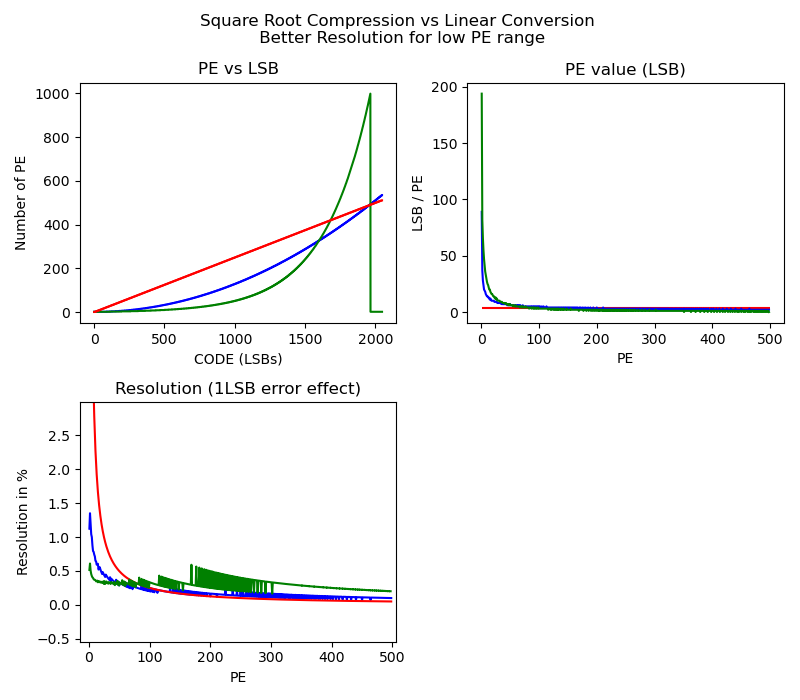

<ipython-input-47-923f78e1373b>:24: RuntimeWarning: divide by zero encountered in true_divide
  RES_LOG = np.divide(np.divide(np.ones(len(PE_LSB_LOG)),PE_LSB_LOG),np.arange(1,MAX_PE-1))*100


In [47]:
fig2 = plt.figure(figsize=(8,7))
fig2.suptitle("Square Root Compression vs Linear Conversion \n Better Resolution for low PE range")
SP1 = fig2.add_subplot(221)
SP1.set_title("PE vs LSB")
SP1.set_xlabel("CODE (LSBs)")
SP1.set_ylabel("Number of PE")
SP1.plot(PE_range_array,'b')
SP1.plot(PE_range_array_LOG,'g')
SP1.plot(PE_range_array_L,'r')

SP2 = fig2.add_subplot(222)
SP2.set_title("PE value (LSB)")
SP2.set_xlabel("PE")
SP2.set_ylabel("LSB / PE")
SP2.plot(np.arange(1,MAX_PE-1),PE_LSB,'b')
SP2.plot(np.arange(1,MAX_PE-1),PE_LSB_LOG,'g')
SP2.hlines(LSB_PE_L,1,MAX_PE-1,colors='r')

SP3 = fig2.add_subplot(223)
SP3.set_title("Resolution (1LSB error effect)")
SP3.set_xlabel("PE")
SP3.set_ylabel("Resolution in %")
RES     = np.divide(np.divide(np.ones(len(PE_LSB)),PE_LSB),np.arange(1,MAX_PE-1))*100
RES_LOG = np.divide(np.divide(np.ones(len(PE_LSB_LOG)),PE_LSB_LOG),np.arange(1,MAX_PE-1))*100
SP3.plot(np.arange(1,MAX_PE-1),RES,'b')
SP3.plot(np.arange(1,MAX_PE-1),RES_L,'r')
SP3.plot(np.arange(1,MAX_PE-1),RES_LOG,'g')

#SP4 = fig2.add_subplot(224)
#SP4.set_title("PE range array")
#SP4.set_xlabel("CONDE (LSBs)")
#SP4.set_ylabel("PE")
#SP4.plot(PE_range_array)

plt.show()
fig2.tight_layout()

<IPython.core.display.Javascript object>


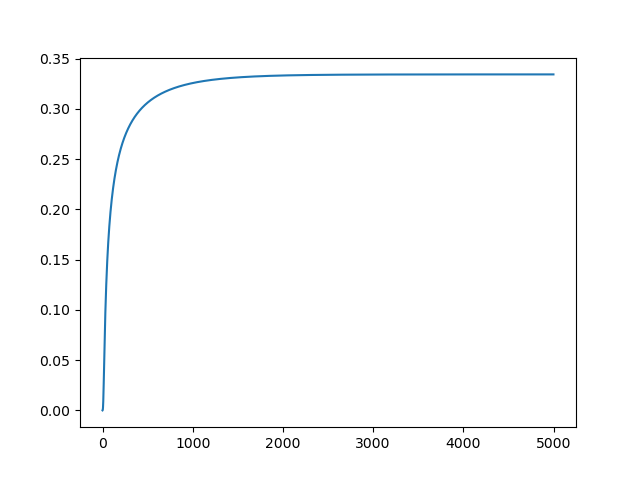

In [14]:
Ibias1 = np.ones(5000)*10E-6
Ibias2 = np.ones(5000)*10E-6
Ibias3 = np.ones(5000)*10E-6
Iin    = signal_out[999*5000:(999+1)*5000] #np.ones(500)*10E-6
test = LOG_integrator(KPP_2n=150E-6, W_L=10, VTH=VTH, time_unit=100E-12, 
                      cap1=10E-12, cap2=2E-12, R=1E3)
plt.figure()
plt.plot(test.ideal(Iin, Ibias1, Ibias2, Ibias3))
#plt.plot(test(Iin, Ibias1, Ibias2, Ibias3))
#print(np.diff(test.ideal(Iin, Ibias1, Ibias2, Ibias3)-test(Iin, Ibias1, Ibias2, Ibias3)))